In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import math 
from utils.io import baumWelch

# Defining Helper Functions

In [2]:
# Function for Encoding Game Quality 
def gameEncoding(x,conditions):
    if x <= conditions[0]:
        out = 0
    if (x > conditions[0]) and (x <= conditions[1]):
        out = 1
    if x > conditions[1]:
        out = 2
    return out


def load_data(file):
    
    # Load Data
    data = pd.read_csv(file)
    
    # Fill Nas with 0
    data.fillna(0,inplace=True)
    
    # Locate players who actually played and had more than 0 seconds 
    gameData = data.loc[(data.did_not_play == 0) & (data.seconds_played > 0)].copy()

    # Check if games played is more than 5
    playerGames = gameData.groupby("name").count()["did_not_play"] >= 5

    # Clean It up and perpare columns for custom index
    gameData = gameData[gameData['name'].isin(playerGames[playerGames==True].index)]
    indexCols = ["field_goal_pct","threePT_pct","free_throws_pct","trb",'assists', 'steals', 'blocks','points']
    
    # Create GameValueIndex
    gameData['GameValueIndex'] = (gameData.loc[:,indexCols].sum(axis = 1) -gameData.loc[:,"turnovers"])/gameData["seconds_played"]
    
    # Quantiles for Game Quality assignment
    conditions= [np.quantile(gameData['GameValueIndex'],0.3),np.quantile(gameData['GameValueIndex'],0.7)]
    
    # 
    gameData["gameQuality"] = gameData["GameValueIndex"].apply(lambda x: gameEncoding(x,conditions))
     
    # Return Data Frame
    return gameData

In [5]:
data1718 = load_data("../data/Players_Data_2017_18.csv")
data1819 = load_data("../data/Players_Data_2018_19.csv")

In [6]:
players1718 = data1718.name.unique()
players1819 = data1819.name.unique()

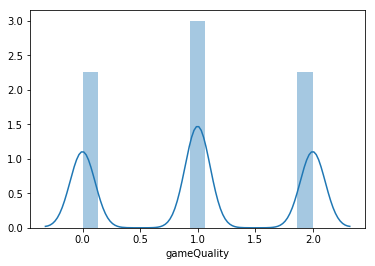

In [7]:
sns.distplot(data1718["gameQuality"])


In [8]:
# Find players found in both seasons
players = (set(players1718) & set(players1819))

# Again filter both seasons by these players 
data17 =  data1718[data1718["name"].isin(players)].copy()
data19 = data1819[data1819["name"].isin(players)].copy()

## Running the Algorithm for Both Seasons

In [9]:
observations =["Bad", "Average", "Good"]
states = ["Cold", "Hot"]

In [10]:
emission_probs = []
for i in range(len(states)):
    for j in range(len(observations)):
        emission_probs.append(observations[j] + " " + states[i])
        
transitions = []
for i in range(len(states)):
    for j in range(len(states)):
        transitions.append(states[i] +  " " + states[j])
        
columns = transitions  + emission_probs
results = pd.DataFrame(index=players, columns=columns)

### 2017  - 18 Season

In [11]:
# Results Data Frame
results17 = pd.DataFrame(index=players, columns=columns)

for player in players:
    # "Global" priors (frome Oscars BBall Knwoledge)
    a = np.array([[0.3,0.7],[0.6,0.4]])
    b = np.array([[0.7, 0.15, 0.15],[0.1, 0.30, 0.60]])
    priors = [0.2,0.8]
    
    # Get Current Player Values
    currentPlayerOutcomes = data17.loc[data17.name == player]["gameQuality"].values
    
    # Run Baum Welch
    transition, emission = baumWelch(currentPlayerOutcomes,a,b,priors,max_iters=50)
    
    # Store Values in Results
    results17.loc[player] = np.concatenate((transition,emission),axis = None)
print("Done") 

Done


### 2018 - 19 Season

In [ ]:
# Results Data Frame
results19 = pd.DataFrame(index=players, columns=columns)

for player in players:
    # "Global" priors (frome Oscars BBall Knwoledge)
    a = np.array([[0.3,0.7],[0.6,0.4]])
    b = np.array([[0.7, 0.15, 0.15],[0.1, 0.30, 0.60]])
    priors = [0.2,0.8]
    
    # Get Current Player Values
    currentPlayerOutcomes = data19.loc[data19.name == player]["gameQuality"].values
    
    # Run Baum Welch
    transition, emission = baumWelch(currentPlayerOutcomes,a,b,priors,max_iters=50)
    
    # Store Values in Results
    results19.loc[player] = np.concatenate((transition,emission),axis = None)
print("Done") 

# Ballers 2017 - 2018

In [12]:
results17[(results17["Cold Cold"] < 0.15) & (results17["Cold Hot"] >= 0.85) & (results17["Good Hot"] > 0.85) & (results17["Good Cold"] >= 0.5)  ]

,Cold Cold,Cold Hot,Hot Cold,Hot Hot,Bad Cold,Average Cold,Good Cold,Bad Hot,Average Hot,Good Hot
Russell Westbrook,0.0451422,0.954858,0.43349,0.56651,0,0.281897,0.718103,0,0.000394782,0.999605
LeBron James,0.141258,0.858742,0.344644,0.655356,0,0.117109,0.882891,0,0.106818,0.893182
James Harden,0.0114515,0.988549,0.492704,0.507296,0,0.125975,0.874025,0,7.44954e-07,0.999999
DeMarcus Cousins,0.1442,0.8558,0.345025,0.654975,0,0.117301,0.882699,0,0.098912,0.901088
Kyrie Irving,0.0394753,0.960525,0.942189,0.0578107,0.0336382,0.401031,0.565331,9.1022e-19,0.0356141,0.964386
Stephen Curry,0.00804335,0.991957,0.353544,0.646456,0,0.451373,0.548627,0,5.86348e-05,0.999941
Joel Embiid,0.123995,0.876005,0.351961,0.648039,0,0.184668,0.815332,0,0.0151645,0.984835
Anthony Davis,0.143563,0.856437,0.346398,0.653602,0,0.131357,0.868643,0,0.115429,0.884571
Karl-Anthony Towns,0.11188,0.88812,0.388674,0.611326,0.0403103,0.454986,0.504703,2.01073e-07,0.0649214,0.935078
Giannis Antetokounmpo,0.00619793,0.993802,0.50391,0.49609,0.0394509,0.157738,0.802811,3.8076e-12,3.34234e-05,0.999967


# Ballers 2018 - 2019

In [ ]:
results19[(results19["Cold Cold"] < 0.15) & (results19["Cold Hot"] >= 0.85) & (results19["Good Hot"] > 0.85) & (results19["Good Cold"] >= 0.5)  ]

In [ ]:
differences.columns

In [ ]:
differences =  results19  - results17


In [ ]:
differences.index[differences["Good Cold"] == differences["Good Cold"].max()]

In [ ]:
results17.loc["John Henson"]

In [ ]:
results19.loc["John Henson"]